# A deterministic surgical tool tip detection algorithm based on segmentation model

## I. Tool tip detection algorithm:


Currently, we are using a ground truth mask instead of a model to focus on the effectiveness of the tool tip determination algorithm, rather than the effectiveness of the segmentation model. However, when we find a good enough segmentation model, we will continue testing.

Our algorithm is a deterministic, training-free algorithm designed to find the tool tip. It is based on skeletonization (using the cv2 library) and employs a graph-based approach, specifically Dijkstra's algorithm.

First of all, let's get acquainted with some concepts:
+ Mask: is an H x W matrix consisting of only pixel 0 (black) and pixel 255 (white) indicating the segmentation of the tool. 
+ Bounding box: is a rectangle $x_1 <= X <= x_2, y_1 <= Y <= y_2$ surrounding the tool. Here the bounding box can be determined through the mask using the formula:
$$
x_1 = \min \left\{ x \mid 0 \le x \le H, \text{ such that there exists } 0 \le y \le W \text{ where } M[x][y] = 255 \right\}
$$
$$
x_2 = \max \left\{ x \mid 0 \le x \le H, \text{ such that there exists } 0 \le y \le W \text{ where } M[x][y] = 255 \right\}
$$
$$
y_1 = \min \left\{ y \mid 0 \le y \le W, \text{ such that there exists } 0 \le x \le H \text{ where } M[x][y] = 255 \right\}
$$
$$
y_2 = \max \left\{ y \mid 0 \le y \le W, \text{ such that there exists } 0 \le x \le H \text{ where } M[x][y] = 255 \right\}
$$

- Abstract edge: We know that a bounding box has four edges. The edges that are close to the boundary (at a distance less than a certain threshold) are called abstract edges. In a bounding box, there are always at most two abstract edges.

- **Handle:** We consider the skeleton matrix $S$ as the set of points $(x,y)$ satisfying $S[x][y] = 255$ (i.e., including the white pixel points). Thus, the handle is the point $s$ belonging to $S$ nearest to the abstract edge of the corresponding bounding box. In the special case where there are two abstract edges, let $A$ be the intersection point of those two abstract edges. Then, the handle is the point $s$ belonging to $S$ nearest to $A$.

- Skeleton graph: To manage the points within the skeleton easily, we construct a graph $ G_S = (V,E) $, where $ V $ represents the set of vertices consisting of points $(x,y)$ satisfying $ S[x][y] = 255 $. If two pixels $ p $ and $ q $ share a common point, we consider them adjacent pixels and add an edge connecting $ p(x_1, y_1) $ and $ q(x_2, y_2) $ to $ E $. Each edge is assigned a weight :

$$ \text{weight}(p,q) = \sqrt{(x_1 - x_2)^2 + (y_1 - y_2)^2} $$

Notice that, $|x_1 - x_2| \leq 1, |y_1 - y_2| \leq 1$.


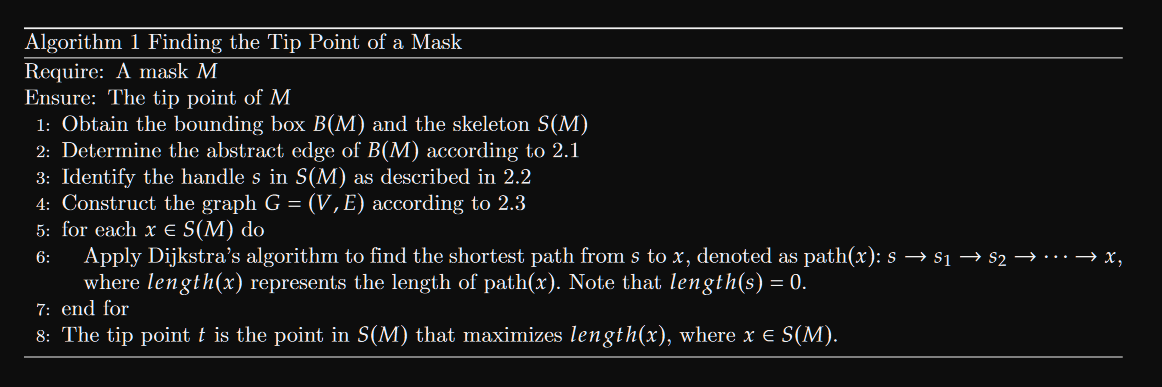

In [1]:
# import cv2
# import os
'''
vid_path is the path to the video you need to convert to frames
dir_path is the path to the folder you save the frames in
comment this cell if you already have the frames
'''

# vid_path = './Segmentation_Robotic_Training/Training/Dataset1/Video.avi'
# dir_path = './Segmentation_Robotic_Training/Training/Dataset1/0'
# if not os.path.exists(dir_path):
#     os.makedirs(dir_path)
# cap = cv2.VideoCapture(vid_path)
# count = 0
# while cap.isOpened():
#     ret, frame = cap.read()
#     if not ret:
#         break
#     cv2.imwrite(dir_path + '/%d.png' % count, frame)
#     count += 1

# cap.release()



: 

In [ ]:
import supervision as sv
from cotracker_utils import *
import networkx as nx
from ROI import *
from Models import *
from Image import *
from LoadEndovis15 import *
from Video import *
from Mask import *

In [ ]:
load = LoadEndovis15(1)
frames = load.process(multiprocessing=False)

In [ ]:
def check(model_tip, abstract_tip, d = 100):
    fit = False
    for tip in abstract_tip:
        # resize tip to fit with current ROI
        tip = (tip[0] - ROI[0][0], tip[1] - ROI[1][0])
        # check if model_tip fit with tip
        fit = (tip[0] - d/2 <= model_tip[0] <= tip[0] + d/2) and (tip[1] - d/2 <= model_tip[1] <= tip[1] + d/2)
    return fit
        

In [ ]:
def evaluate(load, frames, index, d = 100):
    frame = frames[index]
    model_tip, handle, endpoints = frame.getIns()
    tool_tips = [load.tool_tip[i][index][2:] for i in range(len(load.tool_tip))]
    true_pos = [False]*len(model_tip)
    satisfy = [False]*len(tool_tips)
    true_positive = 0
    for idx, tip in enumerate(model_tip):
        true_pos[idx] = False
        for jdx, tool_tip in enumerate(tool_tips):
            # print("tool_tip", tool_tip)
            if(check(tip, tool_tip, d) and not satisfy[jdx]):
                true_pos[idx] = True
                true_positive += 1
                satisfy[jdx] = True
                break
    false_positive = len(model_tip) - true_positive 
    false_negative = 0
    for tool_satisfy in satisfy:
        if not tool_satisfy:
            false_negative += 1
    accuracy = (true_positive) / (true_positive + false_positive + false_negative)
    print(f'Frame index: {index}, accuracy : {accuracy*100}%, TP: {true_positive}, FP: {false_positive}, FN: {false_negative}')
    return accuracy


In [ ]:
jaccard_metric = 0
for idx in range(len(frames)):
    jaccard_metric += evaluate(load, frames, idx)

print(f'Test on {len(frames)} frames, avg jaccard metric: {jaccard_metric/len(frames)*100}%')